# Tarea 06

En el capítulo 7 aprendiste como construir un ETL para mover los datos de una fuente a un data lake en Amazon S3. Asimismo, aprendiste a mover los datos del data lake en Amazon S3 a Amazon Athena para poder hacer transformaciones a tus datos a fin de poder utilizarlos para hacer un análisis.

Esta tarea construye sobre el ejercicio que realizamos la clase anterior con los datos de los Simpsons.

Objetivo:

- Construye un ETL para subir al datalake una tabla con TODOS los episodios de los Simpsons. Los puedes scrapear de esta página https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes_(seasons_1%E2%80%9320)#Season_1_(1989%E2%80%9390)

- Construye un ELT para crear una tabla de episodes en la base de datos de AWS Glue Catalog para que la puedas acceder desde Amazon Athena.

- Visualiza o calcula estadísticas para demostrar si tener una estrella en un episodio aumenta el rating en millones de personas o no.

# Extract

Para obtener los datos, usaremos un webscrapper. Esto nos ahorra, en cierto sentido, algo de trabajo. Por ejemplo, no es necesario hacer *copy-paste* de las 20 tablas de las temporadas

In [4]:
# Importar librerías
import os
import pandas as pd
import numpy as np

In [53]:
# Pasamos la liga de la página de los datos a pandas, para que haga el webscrapping de todas las tablas. 
PATH_EPISODES = "https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes_(seasons_1%E2%80%9320)#Season_1_(1989%E2%80%9390)"
tbls_raw_episodes = pd.read_html(PATH_EPISODES)

In [54]:
len(tbls_raw_episodes)

23

In [55]:
for tbl_index in np.arange(0,23, 1):
    print(tbls_raw_episodes[tbl_index])

   Season Episodes               Originally aired                   \
   Season Episodes Episodes.1         First aired       Last aired   
0       1       13         13   December 17, 1989     May 13, 1990   
1       2       22         22    October 11, 1990    July 11, 1991   
2       3       24         24  September 19, 1991  August 27, 1992   
3       4       22         22  September 24, 1992     May 13, 1993   
4       5       22         22  September 30, 1993     May 19, 1994   
5       6       25         25   September 4, 1994     May 21, 1995   
6       7       25         25  September 17, 1995     May 19, 1996   
7       8       25         25    October 27, 1996     May 18, 1997   
8       9       25         25  September 21, 1997     May 17, 1998   
9      10       23         23     August 23, 1998     May 16, 1999   
10     11       22         22  September 26, 1999     May 21, 2000   
11     12       21         21    November 1, 2000     May 20, 2001   
12     13       22  

Nos interesan solo 20 de las 23 tablas, scrappeadas que son las temporadas de la serie. Los índices de estas tablas van de 1 a la 21.

In [81]:
episodes = []
indexes_of_interest = np.arange(1,22, 1)
indexes_of_interest = np.delete(indexes_of_interest, 18)
for tbl_index in indexes_of_interest:
        episodes.append(tbls_raw_episodes[tbl_index])

y vemos que la longitud de la lista de las temporadas es, en efecto, igual a 20.

In [82]:
len(episodes)

20

y concatenamos todas las tablas

In [83]:
episodes = pd.concat(episodes)

le echamos un vistazo a las tablas concatenadas. Verificamos que se tienen 441 filas, *i.e* 441 episodios de las 20 temporadas.

In [84]:
episodes

,No.overall,No. inseason,Title,Directed by,Written by,Original air date,Prod.code,U.S. viewers(millions)
0,1,1,"""Simpsons Roasting on an Open Fire""",David Silverman,Mimi Pond,"December 17, 1989",7G08,26.7[46]
1,2,2,"""Bart the Genius""",David Silverman,Jon Vitti,"January 14, 1990",7G02,24.5[46]
2,3,3,"""Homer's Odyssey""",Wes Archer,Jay Kogen & Wallace Wolodarsky,"January 21, 1990",7G03,27.5[47]
3,4,4,"""There's No Disgrace Like Home""",Gregg Vanzo & Kent Butterworth,Al Jean & Mike Reiss,"January 28, 1990",7G04,20.2[48]
4,5,5,"""Bart the General""",David Silverman,John Swartzwelder,"February 4, 1990",7G05,27.1[49]
...,...,...,...,...,...,...,...,...
16,437,17,"""The Good, the Sad and the Drugly""",Rob Oliver,Marc Wilmore,"April 19, 2009",LABF07,6.50[481]
17,438,18,"""Father Knows Worst""",Matthew Nastuk,Rob LaZebnik,"April 26, 2009",LABF08,5.94[482]
18,439,19,"""Waverly Hills, 9-0-2-1-D'oh""",Mike Frank Polcino,J. Stewart Burns,"May 3, 2009",LABF10,6.75[483]
19,440,20,"""Four Great Women and a Manicure""",Raymond S. Persi,Valentina L. Garza,"May 10, 2009",LABF09,5.16[484]


# Transform

Tenemos que limpiar algunas columnas de la tabla:
- Uniformizar el nombre de columnas (nombres sin espacio y cada nombre en minúsculas
- Quitar las comillas que encierran el título del episodio
- Quitar los corchetes y números entre ellos, en la columna de million_viwiers.
- Eliminar algunas columnas.

In [85]:
# Define un diccionario con los nombres limpios
DICT_CLEAN_NAMES_SEASONS_TABLE = {
    'No.overall': 'episode_num',
    'No. inseason': 'no_in_season',
    'Title': 'episode_title',
    'Prod.code' : 'prod_code',
    'U.S. viewers(millions)' : 'million_viewers'
}

In [87]:
# Aqui va el preprocesamiento
episodes_raw = (
    episodes
        # Elimina la columna que se duplicó
        .drop(columns=['Original air date', 'Written by', 'Directed by'])
        # Renombrar variables
        .rename(columns = DICT_CLEAN_NAMES_SEASONS_TABLE)
        # Quitar del título del episodio las comillas
        .assign(episode_title=lambda df_: df_.episode_title.str.replace('"', ''))
        # Quitar los numeros entre corchetes de millones de vistas
        .assign(
                # Quitar los numeros entre corchetes de millones de vistas
                million_viewers=lambda df_: df_.million_viewers.str.replace(r'(\[[^\]]*\])', "")
                )
)
episodes_raw.head()

/tmp/ipykernel_16259/3184126798.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  million_viewers=lambda df_: df_.million_viewers.str.replace(r'(\[[^\]]*\])', "")


,episode_num,no_in_season,episode_title,prod_code,million_viewers
0,1,1,Simpsons Roasting on an Open Fire,7G08,26.7
1,2,2,Bart the Genius,7G02,24.5
2,3,3,Homer's Odyssey,7G03,27.5
3,4,4,There's No Disgrace Like Home,7G04,20.2
4,5,5,Bart the General,7G05,27.1


Guardamos en local los datos para depués subirlos al datalake

In [89]:
# Guarda los datos en local
episodes_raw.to_csv("simpsons/raw/simpsons_episodes.csv", index=False)

# Load

In [1]:
# Abrir un cliente de S3
import boto3
s3 = boto3.client('s3')

In [3]:
# Subir al bucket ya existente que se llama
BUCKET_NAME = 'itam-analytics-david'

In [6]:
# Subir archivo a S3 
s3.upload_file(Filename="simpsons/raw/simpsons_episodes.csv", Bucket=BUCKET_NAME, Key="simpsons/raw/episodes/simpsons_episodes.csv")


# ELT

## a) Extract y b) Load

### Crear tabla en la base de datos del CSV en el data lake

In [142]:
import awswrangler as wr

In [143]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `simpsons`.`episodes` (
    `episode_num` string,
    `no_in_season` string,
    `episode_title` string,
    `prod_code` string,
    `million_viewers` string
    ) COMMENT "Catalog of all episodes of Simpsons series."
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-david/simpsons/raw/episodes/'
    TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

Crear tabla en AWS Glue Catalog

In [144]:
wr.athena.read_sql_query(query, database="simpsons", ctas_approach=False)

""


Una observación importante es que el paso de *Extract* está en mover los datos del datalake de S3 a una base de datos en Athena

## c) Transform

Aquí, vamos a ejecutar un query en Athena para unir, usando como clave el número del capítulo (`episode_num`), la tabla de `episodes` con la de `guests`.

In [146]:
query = '''
    CREATE TABLE simpsons.guests_per_episode AS (
        SELECT 
            a.episode_num,
            a.million_viewers,
            a.episode_title,
            b.guest_star
        FROM simpsons.episodes AS a
        LEFT JOIN simpsons.guests AS b
        ON a.episode_num = b.episode_num
    )
'''

In [147]:
wr.athena.read_sql_query(query, database="simpsons", ctas_approach=False)

""


## Analytics

Consumimos la tabla anterior (`simpsons.guests_per_episode`) desde Athena, para reponder: 

**¿tener un invitado especial en un episodio de los Simpsons, incrementa el rating (medido a través de millones de personas que vieron cada capítulo)?**

In [148]:
# query para obtener toda la tabla de guets_per_episodes
query = '''SELECT * FROM simpsons.guests_per_episode'''

In [149]:
# cargamos la tabla a Python como pdDataFrame
tbl_guests_per_episode = wr.athena.read_sql_query(query, database="simpsons", ctas_approach=False)

In [150]:
import pandas as pd

tbl_episodes_guests = (
    tbl_guests_per_episode
        # borrar registros con episodios duplicados
        .drop_duplicates(subset=['episode_num'])
        # columna que indica episodios que tuvieron invitados especiales o no
        .assign(guest_or_no=(~tbl_guests_per_episode['guest_star'].isna()).fillna(0).astype(int))
        # borrar columna con nombres de invitados especiales
        .drop(columns='guest_star')
        # convertir a numerica, la variable de millones de viewers
        .assign(million_viewers=pd.to_numeric(tbl_guests_per_episode['million_viewers'], errors='coerce'))
        .loc[lambda x: x['million_viewers'].notnull()]
        .assign(million_viewers=lambda df_: df_.million_viewers.astype('float'))
)


tbl_episodes_guests.head()

,episode_num,million_viewers,episode_title,guest_or_no
0,1,26.7,Simpsons Roasting on an Open Fire,0
1,2,24.5,Bart the Genius,0
2,3,27.5,Homer's Odyssey,0
3,4,20.2,There's No Disgrace Like Home,0
4,5,27.1,Bart the General,0


In [151]:
len(tbl_episodes_guests)

388

In [152]:
print(tbl_episodes_guests.dtypes)


episode_num         string
million_viewers    float64
episode_title       string
guest_or_no          int64
dtype: object


# ¿Existe diferencia en el rating entre grupos?

Primero podemos comparar gráficamente la población de episodios con y sin invitados

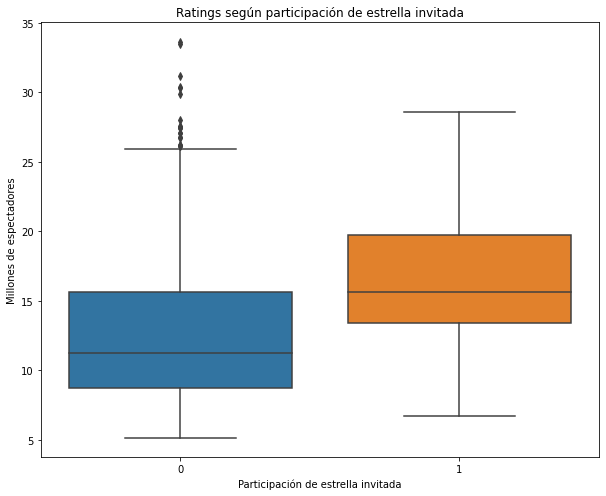

In [162]:
# Crea una figura con tamaño personalizado
fig, ax = plt.subplots(figsize=(10, 8))

# Genera el boxplot
sns.boxplot(x='guest_or_no', y='million_viewers', data=tbl_episodes_guests, ax=ax)

# Añade título y etiquetas de ejes
ax.set_title('Ratings según participación de estrella invitada')
ax.set_xlabel('Participación de estrella invitada')
ax.set_ylabel('Millones de espectadores')

plt.show()

Igualmente podemos ver la media de ratings por conjunto de episodios con invitados o no:

In [163]:
rating_promedio_por_guest_or_no = tbl_episodes_guests.groupby('guest_or_no')['million_viewers'].mean()
rating_promedio_por_guest_or_no

guest_or_no
0    13.371531
1    16.501302
Name: million_viewers, dtype: float64

y la diferencia de medias es positiva, sugiriendo, a priori, que hay un efecto benéfico en el rating cuando se tienen invitados.

Alguien ingenuo podría afirmar, basado en la gráfica o estadpisticas anteriores, que hay un aumento en el rating cuando hay invitados. No obstante, tendría poco sustento científico su respuesta, pues no estaría considerando posible variación muestral o diferencia de medias/medianas debidas al azar. 

Para contestar la pregunta podemos hacer una prueba de diferencia de medias.

Más precisamente, si $X^{(0)}_1,\dots, X^{0}_M$ son los ratings de $M$ episodios que no tuvieron invitados y $X^{(1)}_1,\dots, X^{1}_N$ son los ratings de $N$ episodios que tuvieron invitados, queremos probar
$$
H_0: \delta := \mu^{(1)}-\mu^{(0)}= 0 \qquad  H_1: \delta\neq 0
$$

Si cada población se distribuye de manera normal, entonces podemos aplicar una prueba $t$ de Student. Veamos el qq plot de cada población

In [165]:
with_guests = tbl_episodes_guests.loc[tbl_episodes_guests['guest_or_no'] == 1]
no_guests = tbl_episodes_guests.loc[tbl_episodes_guests['guest_or_no'] == 0]

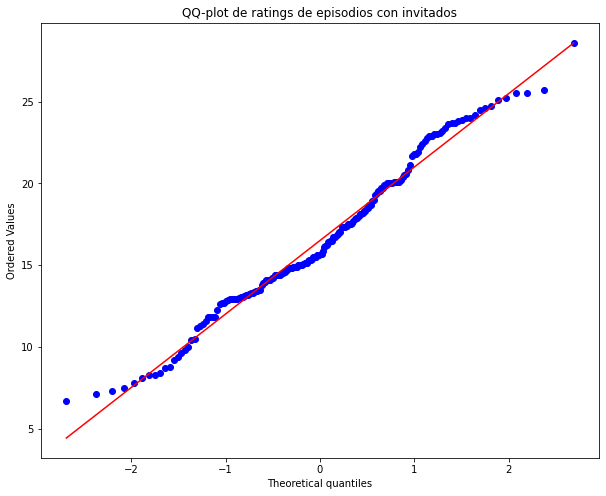

In [177]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
# Graficar el qqplot y añadir un título
fig, ax = plt.subplots(figsize=(10, 8))
stats.probplot(with_guests['million_viewers'], dist="norm", plot=ax)
ax.set_title("QQ-plot de ratings de episodios con invitados")
plt.show()

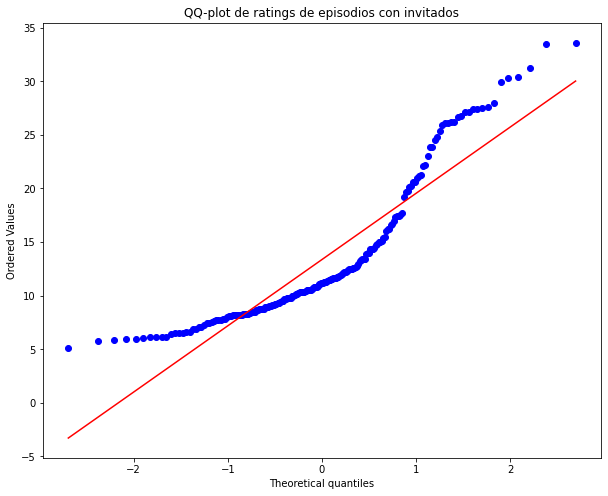

In [178]:
# Graficar el qqplot y añadir un título
fig, ax = plt.subplots(figsize=(10, 8))
stats.probplot(no_guests['million_viewers'], dist="norm", plot=ax)
ax.set_title("QQ-plot de ratings de episodios con invitados")
plt.show()

Aunque los ratings de episodios con invitados son aproximadamente normales, los ratings de episodios sin invitados no lo son claramente. Ambas poblaciones debería ser aproximadamente normales. No obstante podemos aplicar la [Prueba U de Mann-Whitney](https://www.ibm.com/docs/es/spss-statistics/beta?topic=tests-mann-whitney-u-test)

In [176]:
from scipy.stats import mannwhitneyu
# Prueba de Mann-Whitney U
u_stat, p_value = mannwhitneyu(with_guests['million_viewers'], no_guests['million_viewers'])

# Imprimir los resultados
print("Estadística de prueba U: ", u_stat)
print("Valor de p: ", p_value)

Estadística de prueba U:  26805.0
Valor de p:  4.729939496646006e-13


Dado que el valor $p$ (probabilidad de observar una diferencia tan o más extrema como la observada bajo $H_0$)resultó casi cero, rechazamos $H_0$ en favor de $H_1$, lo cual significa que hay un efecto positivo en el rating cuando hay invitados

Igual, ignorando el supuesto de normalidad, si se hace una prueba $t$, la conclusión es la misma

In [175]:
# prueba t de dos muestras
t_stat, p_value = stats.ttest_ind(with_guests['million_viewers'], no_guests['million_viewers'])

# imprimir el resultado
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 5.434673956967785
p-value: 9.747007869227639e-08
